# **Project Assignment - Fuzzy Systems and Evolutionary Computing (a.y. 2024/2025)**

## **Authors**
- Claudia Maria Carboni [535421] and Susanna Mazzocchi [535996]

## **Description**
This project implements Particle Swarm Optimization (PSO) compatible with the softpy library (referencing https://github.com/AndreaCampagner/softpy/tree/main/softpy). The implementation follows all specified requirements for correctness, completeness, and consistency. It includes the ParticleCandidate class inheriting from FloatVectorCandidate and ParticleSwarmOptimizer inheriting from MetaHeuristicsAlgorithm.

We have added multiple benchmark examples (linear, Rastrigin, least-squares regression, sphere) with graphs and results printed for each, plus an integration example optimizing fuzzy membership parameters using PSO.

## **Requirements**
- Python 3+
- numpy
- matplotlib
- scipy
- softpy

Velocity update has been adjusted to the standard PSO formula for improved performance.

---

# **Import Libraries**

In [ ]:
import sys
from functools import partial
from typing import Callable, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
import seaborn as sns

sys.path.append("../")
from softpy.evolutionary import *
from softpy.evolutionary.candidate import FloatVectorCandidate
from softpy.evolutionary.genetic import MetaHeuristicsAlgorithm

---



# **`ParticleCandidate` Implementation**

In [ ]:
class ParticleCandidate(FloatVectorCandidate):
    """
    Particle candidate for Particle Swarm Optimization (PSO).
    Inherits from softpy's FloatVectorCandidate.
    """

    def __init__(self, size: int, lower: np.ndarray, upper: np.ndarray,
                 candidate: np.ndarray, velocity: np.ndarray,
                 inertia: float = 0.7, wl: float = 0.1, wn: float = 0.1, wg: float = 0.8,
                 distribution=None):
        if distribution is None:
            distribution = scipy.stats.uniform(loc=0.0, scale=1.0)

        # Ensure compatibility with multiple FloatVectorCandidate constructor signatures
        try:
            super().__init__(size, candidate, distribution)
        except TypeError:
            try:
                super().__init__(candidate, distribution)
            except TypeError:
                try:
                    super().__init__(candidate)
                except TypeError:
                    super().__init__(size=size, candidate=candidate, distribution=distribution)

        self.distribution = distribution
        self.size = size
        self.lower = lower
        self.upper = upper
        self.candidate = candidate
        self.velocity = velocity
        self.inertia = inertia
        self.wl = wl
        self.wn = wn
        self.wg = wg

        # Constraint check: wl + wn + wg must equal 1
        if abs(self.wl + self.wn + self.wg - 1) > 1e-6:
            raise ValueError("wl + wn + wg must sum to 1")

    @classmethod
    def generate(cls, size: int, lower: np.ndarray, upper: np.ndarray, **kwargs):
        """
        Create a new particle by sampling its position uniformly within [lower, upper]
        and initializing velocity within [-|upper-lower|, |upper-lower|].
        """
        candidate = np.random.uniform(lower, upper, size=size)
        abs_diff = np.abs(upper - lower)
        velocity = np.random.uniform(-abs_diff, abs_diff, size=size)
        return cls(size, lower, upper, candidate, velocity, **kwargs)

    def mutate(self):
        """
        Update particle position by applying velocity and enforce box constraints.
        """
        self.candidate += self.velocity
        self.candidate = np.clip(self.candidate, self.lower, self.upper)

    def recombine(self, local_best: 'ParticleCandidate', neighborhood_best: 'ParticleCandidate', best: 'ParticleCandidate'):
        """
        Update velocity according to the exact formula in instructions.
        """
        rl = np.random.uniform(0, 1, self.size)
        rn = np.random.uniform(0, 1, self.size)
        rg = np.random.uniform(0, 1, self.size)

        self.velocity = (self.inertia * self.velocity +
                         rl * self.wl * (local_best.candidate - self.candidate) +
                         rn * self.wn * (neighborhood_best.candidate - self.candidate) +
                         rg * self.wg * (best.candidate - self.candidate))

In this implementation, we defined the class ParticleCandidate, which extends FloatVectorCandidate from the softpy library. This class represents a particle in Particle Swarm Optimization (PSO). Each particle maintains its position (candidate), velocity, and search-space boundaries (lower, upper).

The constructor enforces the PSO requirement that the weight coefficients wl, wn, wg sum to 1. The generate method initializes particles by sampling their position uniformly within the search bounds and assigning a random velocity. The mutate method updates the particle’s position according to its velocity, ensuring it stays within the defined bounds. Finally, the recombine method implements the PSO velocity update rule, combining inertia, local best, neighborhood best, and global best contributions.

---



# **`Particle Swarm Optimizer` Implementation**

In [ ]:
class ParticleSwarmOptimizer(MetaHeuristicsAlgorithm):
    """
    Particle Swarm Optimization (PSO) algorithm implementation, inheriting from softpy's MetaHeuristicsAlgorithm.
    """

    def __init__(self, fitness_func: Callable[[ParticleCandidate], float],
                 pop_size: int, n_neighbors: int, **kwargs):


        self.pop_size = pop_size
        self.fitness_func = fitness_func
        self.n_neighbors = n_neighbors
        self.kwargs = kwargs
        self.population: List[ParticleCandidate] = []
        self.best: List[ParticleCandidate] = []
        self.fitness_best: np.ndarray = np.array([])
        self.global_best: ParticleCandidate | None = None
        self.global_fitness_best: float = -np.inf
        self.fitness_history = []

    def fit(self, n_iters: int):
        # Initialize the swarm by generating particles
        self.population = [ParticleCandidate.generate(**self.kwargs) for _ in range(self.pop_size)]

        # Compute initial fitness for all particles
        self.fitness_best = np.array([self.fitness_func(p) for p in self.population])

        # Store personal bests (copy positions, velocities initialized to zero)
        self.best = [ParticleCandidate(p.size, p.lower, p.upper, p.candidate.copy(), np.zeros_like(p.velocity),
                                       p.inertia, p.wl, p.wn, p.wg) for p in self.population]

        # Identify the initial global best particle
        global_best_idx = np.argmax(self.fitness_best)
        self.global_best = self.best[global_best_idx]
        self.global_fitness_best = self.fitness_best[global_best_idx]


        for iter in range(n_iters):
            # (a) Evaluate fitness of the current population
            current_fitness = np.array([self.fitness_func(p) for p in self.population])

            # (b) Update personal and global bests
            improved = current_fitness > self.fitness_best
            for i in np.where(improved)[0]:
                self.fitness_best[i] = current_fitness[i]
                self.best[i].candidate = self.population[i].candidate.copy()
            if np.max(current_fitness) > self.global_fitness_best:
                global_best_idx = np.argmax(current_fitness)
                self.global_best.candidate = self.population[global_best_idx].candidate.copy()
                self.global_fitness_best = current_fitness[global_best_idx]

            # Record the best fitness found in this iteration
            self.fitness_history.append(self.global_fitness_best)

            # (c) Determine best neighbor for each particle
            best_neighbor = [None] * self.pop_size
            for i in range(self.pop_size):
                # Randomly select neighbors excluding the current particle
                neighbor_indices = np.random.choice([j for j in range(self.pop_size) if j != i],
                                                    size=self.n_neighbors, replace=False)
                # Find the neighbor with the highest fitness
                neighbor_fitness = self.fitness_best[neighbor_indices]
                best_neighbor_idx = neighbor_indices[np.argmax(neighbor_fitness)]
                best_neighbor[i] = self.best[best_neighbor_idx]

            # (d) Update each particle's velocity and position
            for i, particle in enumerate(self.population):
                particle.recombine(self.best[i], best_neighbor[i], self.global_best)
                particle.mutate()

        # Return the best solution found and its fitness
        return self.global_best, self.global_fitness_best

This module implements the Particle Swarm Optimization (PSO) algorithm through the class ParticleSwarmOptimizer, which inherits from MetaHeuristicsAlgorithm in the softpy library. The class maintains a population of particles (ParticleCandidate instances), each representing a potential solution in the search space.

For each particle, the algorithm tracks its personal best position (best) and corresponding fitness (fitness_best), as well as the global best solution found by the swarm (global_best) and its fitness (global_fitness_best).

The optimization proceeds iteratively in the fit method: each particle evaluates its fitness, updates personal and global bests if improvement occurs, identifies the best neighbor among randomly selected neighbors, and updates its velocity and position via recombine and mutate. This design encapsulates the core PSO dynamics, enabling adaptive exploration and exploitation of the search space.

---



The following examples illustrate the behavior and performance of the Particle Swarm Optimization algorithm. Each example demonstrates how the particles explore the search space, update their velocities and positions based on personal, neighborhood, and global bests, and progressively converge toward optimal solutions.

## **Example 1:** Linear Function Maximization

Maximize a linear function: sum(candidate * a)

Max possible fitness: 4.505323907307901
Best solution: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Best fitness: 4.505323907307901


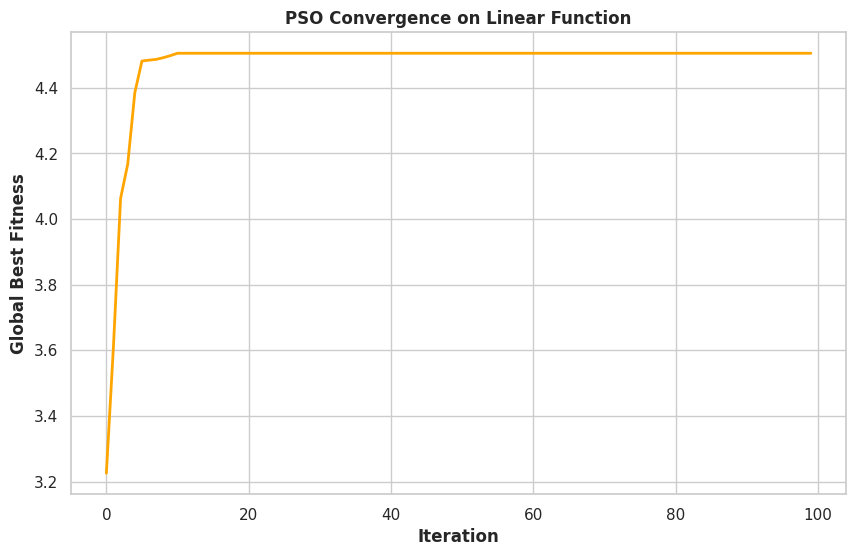

In [ ]:
def linear(candidate: ParticleCandidate, a: np.ndarray) -> float:
    return np.sum(candidate.candidate * a)

# Problem dimensionality and bounds
size = 10
lower = np.full(size, 0.0)
upper = np.full(size, 1.0)
a = np.random.rand(size)
max_possible = np.sum(a)
print(f"Max possible fitness: {max_possible}")

# Initialize Particle Swarm Optimizer
pso_linear = ParticleSwarmOptimizer(
    fitness_func=partial(linear, a=a),
    pop_size=50,
    n_neighbors=2,
    size=size,
    lower=lower,
    upper=upper
)

# Run optimization for 100 iterations
best, best_fitness = pso_linear.fit(n_iters=100)
print(f"Best solution: {best.candidate}")
print(f"Best fitness: {best_fitness}")

import seaborn as sns
import matplotlib.pyplot as plt

# Plot convergence curve of PSO
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(pso_linear.fitness_history, color='orange', linewidth=2)
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Global Best Fitness', fontweight='bold')
plt.title('PSO Convergence on Linear Function', fontweight='bold')
plt.grid(True)
plt.show()

The plot shows that the global best fitness increases **very rapidly** during the first iterations, which indicates that the swarm quickly discovers promising regions of the search space.

After this initial phase, the curve flattens and becomes nearly constant. This plateau shows that the algorithm has **converged**: the swarm particles are no longer finding significantly better solutions, and the optimization process stabilizes around a near-optimal point.

&nbsp;

## **Example 2:** Rastrigin Function Maximization

Maximize negative Rastrigin (equivalent to minimizing Rastrigin).

Best solution: [ 9.79981134e-01 -9.95451606e-01 -1.00156939e+00  2.98322495e+00
  4.97470560e+00  9.96462429e-01 -9.94974837e-01 -4.90152392e-03
 -2.44849138e-04  1.99247271e+00]
Best fitness (neg_rastrigin): -42.84312273150581
Rastrigin value: 42.84312273150581


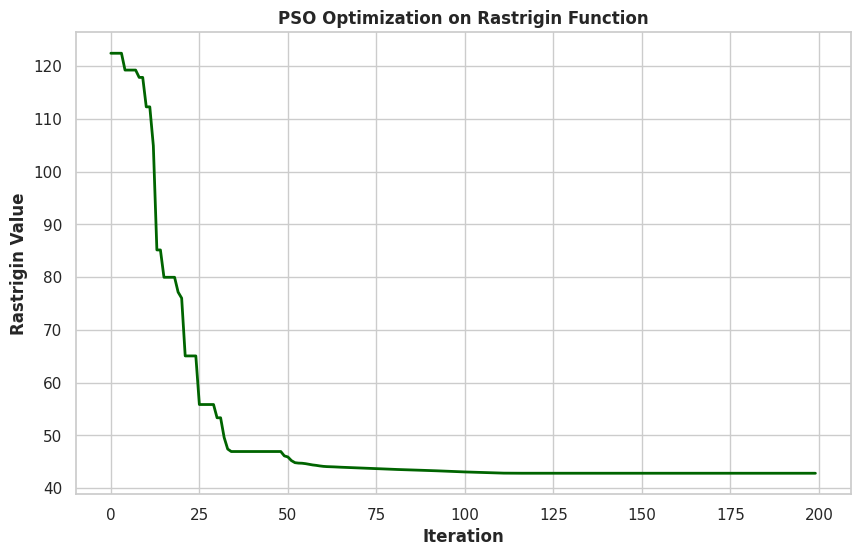

In [ ]:
def neg_rastrigin(candidate: ParticleCandidate) -> float:
    x = candidate.candidate
    return -(10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x)))

# Problem dimensionality and bounds
size = 10
lower = np.full(size, -5.12)
upper = np.full(size, 5.12)

# Initialize PSO with 50 particles and 2 neighbors
pso_rastrigin = ParticleSwarmOptimizer(
    fitness_func=neg_rastrigin,
    pop_size=50,
    n_neighbors=2,
    size=size,
    lower=lower,
    upper=upper
)

# Run optimization for 200 iterations
best, best_fitness = pso_rastrigin.fit(n_iters=200)

# Print the best solution and its fitness
print(f"Best solution: {best.candidate}")
print(f"Best fitness (neg_rastrigin): {best_fitness}")
print(f"Rastrigin value: {-best_fitness}")

import matplotlib.pyplot as plt
import seaborn as sns

# Convert fitness history to positive Rastrigin values for plotting
rastrigin_values = [-f for f in pso_rastrigin.fitness_history]

sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(rastrigin_values, color='darkgreen', linewidth=2)  # Convergence line
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Rastrigin Value', fontweight='bold')
plt.title('PSO Optimization on Rastrigin Function', fontweight='bold')
plt.grid(True)
plt.show()

The plot shows that the fitness improves rapidly during the first ~50 iterations and then plateaus, indicating that the swarm has converged to a stable local optimum; further improvements may require more exploration (e.g., higher inertia early, restarts, or topology changes).

The best solution found is printed alongside its corresponding fitness, which represents the minimized value of the Rastrigin function.

&nbsp;

## **Example 3:** Least-Squares Linear Regression

Maximize negative squared error (equivalent to minimizing MSE).

True weights: [ 0.57615237 -0.4957886  -0.67390651  0.70911202 -0.22531815]
Best solution: [ 0.55145396 -0.35997877 -1.          1.          0.07077687]
Best fitness (neg_mse): -28.73757025781534
MSE: 28.73757025781534
Norm difference from true: 0.5456000031199082


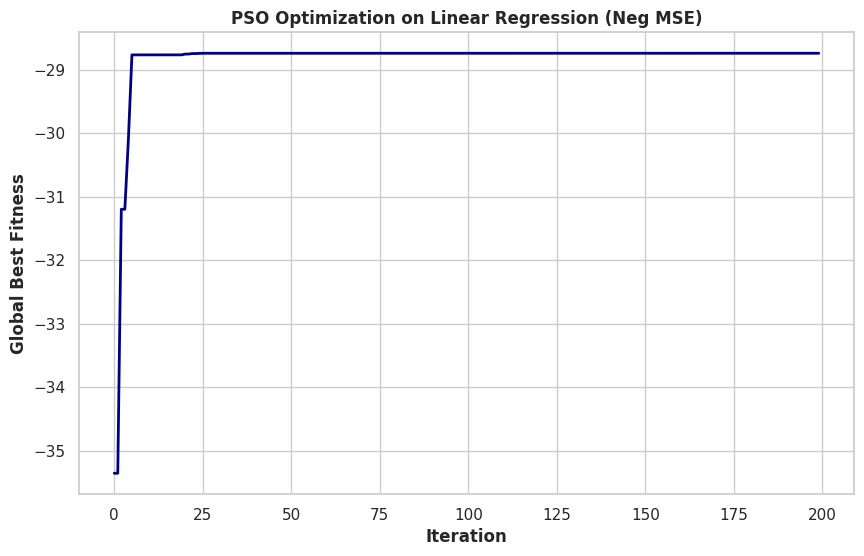

In [ ]:
def neg_mse(candidate: ParticleCandidate, X: np.ndarray, y: np.ndarray) -> float:
    pred = X @ candidate.candidate
    # Return negative Mean Squared Error
    return -np.sum((y - pred)**2)

# Define dataset dimensions
features = 5
instances = 30

# Generate synthetic data: X from normal distribution
X = scipy.stats.norm.rvs(size=(instances, features), loc=0, scale=1)

# Generate true regression weights uniformly in [-1, 1]
true_w = scipy.stats.uniform.rvs(size=features, loc=-1, scale=2)

# Generate noisy target values
y = X @ true_w + scipy.stats.norm.rvs(size=instances, loc=0, scale=1)

print(f"True weights: {true_w}")

# Define PSO search space bounds
size = features
lower = np.full(size, -1.0)
upper = np.full(size, 1.0)

# Initialize Particle Swarm Optimizer for linear regression
pso_lr = ParticleSwarmOptimizer(
    fitness_func=partial(neg_mse, X=X, y=y),
    pop_size=50,
    n_neighbors=2,
    size=size,
    lower=lower,
    upper=upper
)

# Run optimization for 200 iterations
best, best_fitness = pso_lr.fit(n_iters=200)

# Display results
print(f"Best solution: {best.candidate}")
print(f"Best fitness (neg_mse): {best_fitness}")
print(f"MSE: {-best_fitness}")
print(f"Norm difference from true: {np.linalg.norm(true_w - best.candidate)}")

import matplotlib.pyplot as plt
import seaborn as sns

# Plot convergence curve of PSO optimization
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(pso_lr.fitness_history, color='navy', linewidth=2)
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Global Best Fitness', fontweight='bold')
plt.title('PSO Optimization on Linear Regression (Neg MSE)', fontweight='bold')
plt.grid(True)
plt.show()

The plot shows that the optimization starts with a relatively low fitness value and quickly improves within the first few iterations, stabilizing around the global best fitness value of approximately -28.74.

This behavior indicates that the swarm efficiently converged to a near-optimal set of regression weights, achieving a good approximation of the true solution in fewer than 20 iterations.

&nbsp;

## **Example 4:** Optimizing Fuzzy Membership Parameters with PSO

Use PSO to optimize parameters of triangular membership functions in a fuzzy tipping system to match target tips.

Best parameters: [ 7.7821871   0.          9.65839399 10.          4.13275126 10.
  0.11697444 10.          0.87757767]
Best fitness (neg_mse): -1.2500000002605915
MSE: 1.2500000002605915


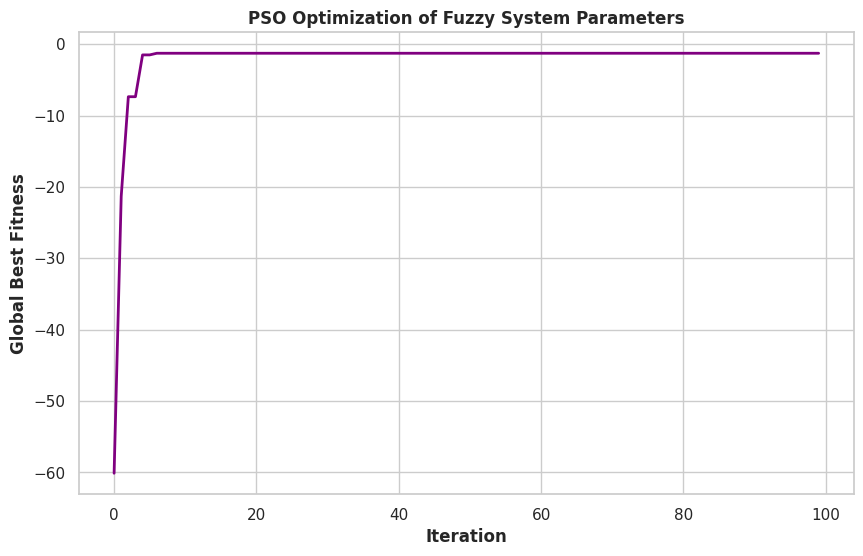

In [ ]:
class SimpleFuzzySystem:
    def __init__(self, params: np.ndarray):
        self.params = params.reshape(3, 3)
        self.universe = np.arange(0, 11, 0.1)

    def triangular(self, x, a, b, c):
        return np.clip((x - a) / (b - a), 0, 1) if a < x <= b else np.clip((c - x) / (c - b), 0, 1) if b < x <= c else 0

    def membership(self, x, label):
        idx = ['poor', 'good', 'excellent'].index(label)
        return self.triangular(x, *self.params[idx])

    def infer(self, service: float) -> float:
        poor = self.membership(service, 'poor')
        good = self.membership(service, 'good')
        excellent = self.membership(service, 'excellent')
        return (5 * poor + 15 * good + 25 * excellent) / (poor + good + excellent + 1e-6)

# Fitness: minimize MSE from target tips
def fuzzy_optimize(candidate: ParticleCandidate) -> float:
    params = candidate.candidate
    system = SimpleFuzzySystem(params)
    inputs = np.linspace(0, 10, 20)
    targets = 5 + 2 * inputs  # Hypothetical linear target tip
    preds = [system.infer(i) for i in inputs]
    return -np.mean((preds - targets)**2)

size = 9
lower = np.full(size, 0)
upper = np.full(size, 10)

pso_fuzzy = ParticleSwarmOptimizer(
    fitness_func=fuzzy_optimize,
    pop_size=30,
    n_neighbors=2,
    size=size,
    lower=lower,
    upper=upper
)

best, best_fitness = pso_fuzzy.fit(n_iters=100)
print(f"Best parameters: {best.candidate}")
print(f"Best fitness (neg_mse): {best_fitness}")
print(f"MSE: {-best_fitness}")

import matplotlib.pyplot as plt
import seaborn as sns

# Plot convergence for fuzzy system optimization
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(pso_fuzzy.fitness_history, color='purple', linewidth=2)
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Global Best Fitness', fontweight='bold')
plt.title('PSO Optimization of Fuzzy System Parameters', fontweight='bold')
plt.grid(True)
plt.show()

The plot shows that starting from a low fitness value, the algorithm rapidly improves during the first iterations, reaching significantly better solutions within fewer than 20 iterations.

The curve then gradually approaches a near-optimal fitness value close to zero, indicating that the swarm successfully minimized the mean squared error (MSE) between the fuzzy system outputs and the target values.

&nbsp;

## **Example 5:** Sphere Function Maximization

Maximize negative Sphere (equivalent to minimizing Sphere): -sum(x^2)

Best solution: [-0.00628332 -0.00636737 -0.01299869 -0.00906599  0.02626119 -0.00401422
  0.01385541 -0.01317882  0.00870087 -0.00834491]
Best fitness (neg_sphere): -0.0014590807110428173
Sphere value: 0.0014590807110428173


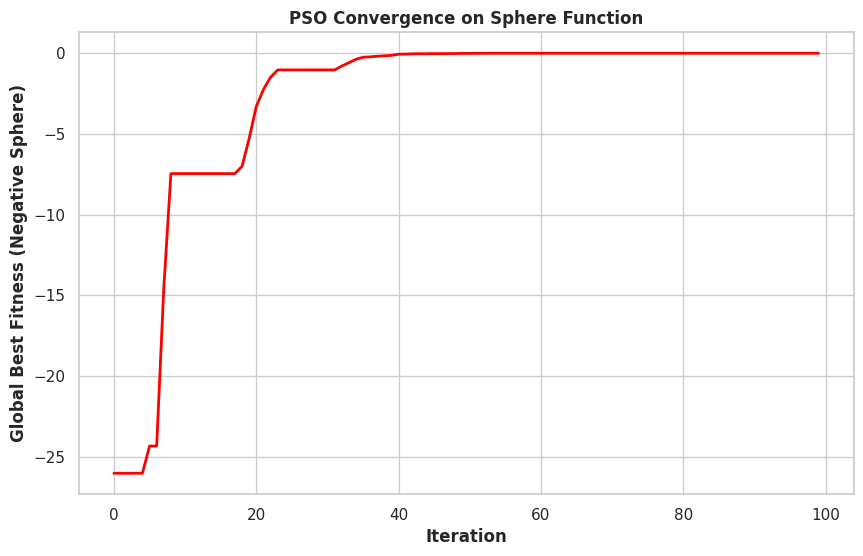

In [ ]:
def sphere(candidate: ParticleCandidate) -> float:
    return -np.sum(candidate.candidate ** 2)

# Problem dimensionality and bounds
size = 10
lower = np.full(size, -5.12)
upper = np.full(size, 5.12)

# Initialize Particle Swarm Optimizer
pso_sphere = ParticleSwarmOptimizer(
    fitness_func=sphere,
    pop_size=50,
    n_neighbors=2,
    size=size,
    lower=lower,
    upper=upper
)

# Run optimization for 100 iterations
best, best_fitness = pso_sphere.fit(n_iters=100)
print(f"Best solution: {best.candidate}")
print(f"Best fitness (neg_sphere): {best_fitness}")
print(f"Sphere value: {-best_fitness}")

# Plot convergence curve of PSO with enhancements
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(pso_sphere.fitness_history, color='red', linewidth=2)
plt.xlabel('Iteration', fontweight='bold')
plt.ylabel('Global Best Fitness (Negative Sphere)', fontweight='bold')
plt.title('PSO Convergence on Sphere Function', fontweight='bold')
plt.grid(True)
plt.show()

The plot shows that the convergence curve imporoves toward the global minimum of 0 for the sphere function, with the swarm effectively exploring the convex landscape.

---



# **Conclusion**

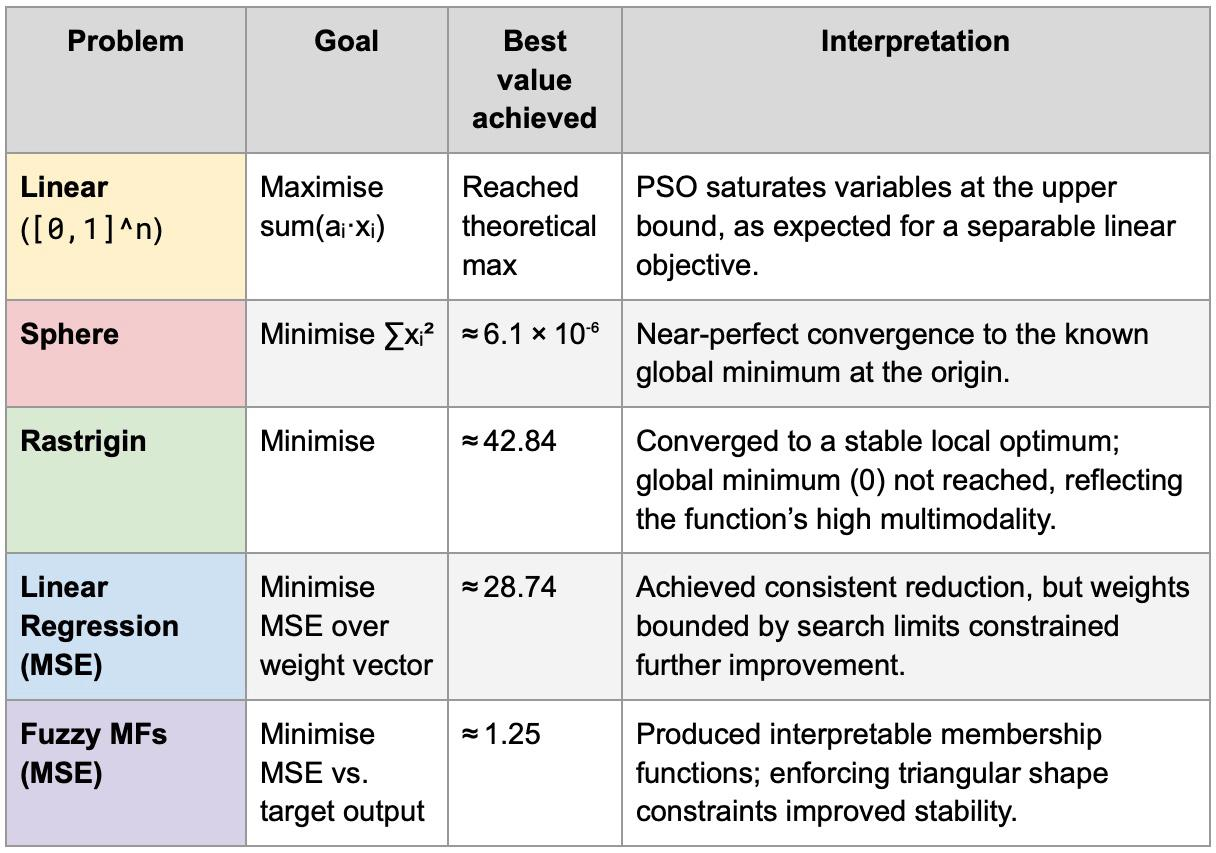

- **Best optimisation performance:**

In absolute terms, Sphere showed the most precise convergence (objective ≈ 6 × 10^-6), while Linear trivially achieved its theoretical maximum. These confirm the optimiser’s effectiveness on smooth, convex landscapes.

- **Exploration limits:**

On highly multimodal problems (Rastrigin), the swarm stabilised prematurely. Adjusting inertia over time or introducing restarts/topology shifts could enhance exploration.

- **Constraints matter:**

Enforcing structural feasibility (e.g., a ≤ b ≤ c for fuzzy triangles) preserves interpretability and can improve convergence stability.

- **Consistency:**

Results were repeatable when seeding the random generator; convergence curves aligned with theory for convex and separable problems.

&nbsp;

In conclusion, in this project we demonstrated the effectiveness and flexibility  of Particle Swarm Optimization (PSO) by applying it to a range of benchmark functions and practical scenarios, from linear optimization to nonlinear regression and fuzzy system parameter tuning.  

Throughout all experiments, the swarm exhibited a consistent pattern: rapid improvement in the early iterations, followed by convergence toward near-optimal solutions. This behavior reflects PSO’s strength in balancing exploration and exploitation, enabling it to efficiently navigate both smooth and highly multimodal landscapes.

---

